Headers

In [1]:

import kaleido
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import datetime
import calendar
import statsmodels.api as sm
from plotly.graph_objects import Layout
import plotly.io as pio
import plotly.figure_factory as ff
from urllib.request import urlopen
import json
import geopandas as gpd
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon


BarChart

In [2]:
name = '262\Production_By_Owner.csv'
df = pd.read_csv(name)
df_23 = pd.read_csv('262\Production_By_Owner_2023.csv')
df["Oil"] = [0 if x == " -" else x for x in df['Oil']]
df['BOE'] = df['BOE']/30
df['result'] = df["Oil"].astype(float)/df["Gas"].astype(float)*100

df = df.loc[0:9]
df_23 = df_23.loc[0:9]
df_23['BOE'] = df_23['BOE']/30

fig = go.Figure()

fig.add_trace(go.Bar(x=df['BOE'],
                y=df['OwnerNameProd'],
                name='2022',
                marker_color='rgb(68, 94, 197)',
                orientation='h', 
                marker=dict(cornerradius=60),
                ))
fig.add_trace(go.Bar(x=df_23['BOE'],
                y=df['OwnerNameProd'],
                name='2023',
                marker_color='rgb(255, 145, 77)',
                orientation='h', 
                marker=dict(cornerradius=60)
                ))

lineColor = 'gray'
fig.update_xaxes(showline=True, linewidth=1, linecolor=lineColor, gridcolor='gray')
fig.update_yaxes(showline=True, linewidth=1, linecolor=lineColor, gridcolor='white')

fig.update_layout(
    xaxis_title='BOE',
    width=980,
    height=432,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor= 'rgba(0, 0, 0, 0)',
    margin=dict(t=30, r=30, l=30, b=30),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    legend=dict(
        yanchor="top",
        y=0.2,
        xanchor="right",
        x=0.95
    ),
    font=dict(
        family="Roboto Condensed Regular",
        size=18,
        color="#595959"
    ),
    yaxis=dict(autorange="reversed")
)

fig.write_image("bar.png", scale=4, width=980, height=432)
fig.show()

Lowess

In [3]:

name = '262\_BOE_Production__04_06_24(_BOE_(BBL)_).csv'
df = pd.read_csv(name)
df['BOE (BBL)'] = df['BOE (BBL)']/30
df["BOE Production"] = pd.to_datetime(df["BOE Production"], format="%Y-%m-%d")

name = '262\_Gas_Production__04_09_24(_Gas_(BBL)_).csv'
df_gas = pd.read_csv(name)
df_gas["Gas Production"] = pd.to_datetime(df_gas["Gas Production"], format="%Y-%m")


cond1 = df["BOE Production"] >= pd.Timestamp(2020,1,1)
df = df.loc[cond1, ]
df['year'] = [x.year for x in df['BOE Production']]
df['month'] = [x.month for x in df['BOE Production']]

fig = go.Figure()

performance_line = pd.DataFrame(sm.nonparametric.lowess(df["BOE (BBL)"], df['BOE Production'].values.astype(float), frac=0.3))
fig.add_trace(
    go.Scatter(
        x=pd.to_datetime(performance_line[0]),
        y=performance_line[1],
        mode='lines',
        name='Lowess Trendline',
        line_shape='spline',
        line=dict(
            width=3,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=df["BOE Production"], 
        y=df["BOE (BBL)"],
        mode='lines',
        name='Daily Production',
        line_shape='spline',
        line=dict(
            width=5,
            color='rgba(255,130,40,1)'
        ),
        
    )
)



fig.update_layout(
    font=dict(
        family="Roboto Condensed",
        size=18,
        color="#595959"
    ),
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=30, r=30, l=30, b=30),
    width=588, height=288,
    legend=dict( 
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.01
    ),
    xaxis_title="Year",
    yaxis_title="Daily BOE"
)

lineColor = 'gray'
fig.update_xaxes(
    tickformat="%Y",
    ticklabelmode="period", title_font=dict(size=14), title_standoff=3,
    showline=True, linewidth=1, linecolor=lineColor, gridcolor='gray')
fig.update_yaxes(title_font=dict(size=14), title_standoff=3,
                 showline=True, linewidth=1, linecolor=lineColor, gridcolor='gray')

#fig.data[1].name = 'Trendline'
#fig.data[1].showlegend = True

fig.update_traces(visible=False, selector=dict(mode="markers"))

fig.write_image("fig1.png", scale=4, width=980, height=720)
fig.show()



Ols and fill

In [12]:
name = '262\_BOE_Production__04_06_24(_BOE_(BBL)_).csv'
df = pd.read_csv(name)
df['BOE (BBL)'] = df['BOE (BBL)']/30
df["BOE Production"] = pd.to_datetime(df["BOE Production"], format="%Y-%m-%d")

name = '262\_Gas_Production__04_09_24(_Gas_(BBL)_).csv'
df_gas = pd.read_csv(name)
df_gas["Gas Production"] = pd.to_datetime(df_gas["Gas Production"], format="%Y-%m")



df['year'] = [x.year for x in df['BOE Production']]
df['month'] = [x.month for x in df['BOE Production']]

fig = go.Figure()
df['date_delta'] = (df['BOE Production'] - df['BOE Production'].min())  / np.timedelta64(1,'D')
df['bestfit'] = sm.OLS(df["BOE (BBL)"], sm.add_constant(df["date_delta"])).fit().fittedvalues
fig.add_trace(
    go.Scatter(
        name='Trendline', x=df["BOE Production"], y=df['bestfit'], mode='lines', 
        line = dict(color='rgba(99,110,250,1)', width=2)
    )
)

fig.add_trace(
    go.Scatter(
        x=df["BOE Production"], 
        y=df["BOE (BBL)"],
        mode='lines',
        name='Daily Production',
        line_shape='spline',
        line=dict(
            width=3,
            color='rgba(255,130,40,1)'
        ),
        fill='tozeroy', line_color='rgba(255,130,40,1)'
    )
)

fig.add_trace(
    go.Scatter(
        x=df_gas["Gas Production"], 
        y=df_gas["Gas (BBL)"],
        mode='lines',
        name='Gas Production',
        line_shape='spline',
        line = dict(color='rgba(220,98,92,1)', width=1),
        fill='tozeroy', line_color='rgba(220,98,92,1)'
    )
)
width = 980
height = 720
fig.update_layout(
    font=dict(
        family="Roboto Condensed",
        size=18,
        color="#595959"
    ),
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=30, r=30, l=30, b=30),
    width=width, height=height,
    legend=dict( 
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.01
    ),
    xaxis_title="Year",
    yaxis_title="Daily BOE"
)

lineColor = 'gray'
fig.update_xaxes(
    tickformat="%Y",
    ticklabelmode="period", title_font=dict(size=14), title_standoff=3,
    showline=True, linewidth=1, linecolor=lineColor, gridcolor='gray')
fig.update_yaxes(title_font=dict(size=14), title_standoff=3,
                 showline=True, linewidth=1, linecolor=lineColor, gridcolor='gray')

#fig.data[1].name = 'Trendline'
#fig.data[1].showlegend = True

fig.update_traces(visible=False, selector=dict(mode="markers"))

fig.write_image("fig1.png", scale=4, width=width, height=width)
fig.write_html("graph.html")
fig.show()

Treemap

In [4]:
name = '262\Production_By_Owner_23_Mar.csv'
df1 = pd.read_csv(name)
df1 = df1.loc[0:9]
#df1.loc['Total'] = pd.Series(df1['BOE'].sum(), index=['BOE'])
#df1.loc['Total', 'OwnerNameProd'] = 'Other'
df1['region'] = ['Marcellus shale' for x in df1['OwnerNameProd']]

name = '262\Production_By_Owner_23_Utica.csv'
df2 = pd.read_csv(name)
df2 = df2.loc[0:9]
#df2.loc['Total'] = pd.Series(df2['BOE'].sum(), index=['BOE'])
#df2.loc['Total', 'OwnerNameProd'] = 'Other'
df2['region'] = ['Utica shale' for x in df2['OwnerNameProd']]

df1 = pd.concat([df1, df2])

fig = px.treemap(df1, path=[px.Constant("Appalachian Basin"), 'region', 'OwnerNameProd'], values='BOE',
                  color='Producing Wells', labels={"Producing Wells": "Wells"},
                  color_continuous_scale='RdBu')

fig.update_layout(
    margin = dict(t=25, l=25, r=25, b=25),
    width=980, height=720,
    font=dict(
        family="Roboto Condensed",
        size=22,
        color="#595959"
    )
)
fig.show()
pio.write_image(fig, "op.png", scale=4, width=980, height=720)


In [5]:
name = '262\Production_By_Owner_2023.csv'
df1 = pd.read_csv(name)
df1 = df1.loc[0:9]
df1.loc['Total'] = pd.Series(df1['BOE'].sum(), index=['BOE'])
df1.loc['Total', 'OwnerNameProd'] = 'Other'
df1['region'] = ['Marcellus' for x in df1['OwnerNameProd']]

fig = px.treemap(df1, path=[px.Constant("App"), 'OwnerNameProd'], values='BOE',
                  color='Producing Wells',
                  color_continuous_scale='deep_r')

fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    width=980,
    height=720,
)
fig.show()

Map testing

c:\Users\solnate\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



[' Ohio' ' Pennsylvania']
                                             geometry          name
34  POLYGON ((-80.51860 41.97880, -80.51860 40.636...          Ohio
37  POLYGON ((-79.76278 42.25265, -79.76278 42.000...  Pennsylvania


c:\Users\solnate\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



<Axes: >

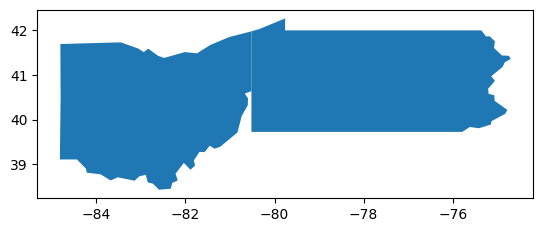

In [6]:
name = '262\Well_Header_Details (1).csv'
df = pd.read_csv(name)
states = df['State'].unique()
usa = pd.read_json("geo/us-states.json")
usa_df = gpd.GeoDataFrame.from_features(usa['features'])

print(states)
ohio = usa_df.loc[(usa_df['name'] == 'Ohio') | (usa_df['name'] == 'Pennsylvania')]
print(ohio)
ohio.plot()

Other

In [7]:
name = '262\_BOE_Production__04_06_24(_BOE_(BBL)_).csv'
df = pd.read_csv(name)
df["BOE Production"] = pd.to_datetime(df["BOE Production"], format="%Y-%m-%d")

df['year'] = [x.year for x in df['BOE Production']]
df['month'] = [x.month for x in df['BOE Production']]

layout = Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)

cond = (df["BOE Production"] >= pd.Timestamp(2022,1,1)) & (df["BOE Production"] < pd.Timestamp(2023,1,1))
fig.add_trace(go.Scatter(
    x=df.loc[cond, ]["month"], 
    y=df.loc[cond, ]["BOE (BBL)"],
    mode='lines',
    name='2022',
    line_shape='spline')
)

cond = (df["BOE Production"] >= pd.Timestamp(2023,1,1)) & (df["BOE Production"] < pd.Timestamp(2023,10,1))
fig.add_trace(go.Scatter(
    x=df.loc[cond, ]["month"], 
    y=df.loc[cond, ]["BOE (BBL)"],
    mode='lines',
    name='2023',
    line_shape='spline')
)

cond = (df["BOE Production"] >= pd.Timestamp(2023,1,1)) & (df["BOE Production"] < pd.Timestamp(2023,10,1))
# linear regression
regline = sm.OLS(df.loc[cond, ]["BOE (BBL)"],sm.add_constant(df.loc[cond, ]["month"])).fit().fittedvalues
# add linear regression line for whole sample
fig.add_traces(go.Scatter(
    x=df.loc[cond, ]["month"], y=regline,
    mode = 'lines',
    name='trend 2023')
)

lineColor = 'gray'
fig.update_xaxes(showline=True, linewidth=1, linecolor=lineColor, gridcolor=lineColor)
fig.update_yaxes(showline=True, linewidth=1, linecolor=lineColor, gridcolor=lineColor)

fig.update_layout(
    yaxis_title='BOE',
    xaxis_title='Date',
    plot_bgcolor= 'rgba(0, 0, 0, 0)',
    showlegend=False,
    margin=dict(t=20, r=20)
)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [x for x in df[df["year"] == 2022]["month"]],
        ticktext = [calendar.month_name[x] for x in df[df["year"] == 2022]["month"]]
    )
)

fig.show()